In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import joblib

In [20]:
joined_data = pd.read_csv('cleaned_property_data.csv')

In [21]:
# Prepare data 
le_type = LabelEncoder()
le_zipcode = LabelEncoder()
le_borough = LabelEncoder()
le_neighborhood = LabelEncoder()

joined_data['TYPE_ENCODED'] = le_type.fit_transform(joined_data['TYPE'])
joined_data['ZIPCODE_ENCODED'] = le_zipcode.fit_transform(joined_data['ZIPCODE'])
joined_data['BOROUGH_ENCODED'] = le_borough.fit_transform(joined_data['BOROUGH'])
joined_data['NEIGHBORHOOD_ENCODED'] = le_neighborhood.fit_transform(joined_data['NEIGHBORHOOD'])

In [22]:
# Perform K-means clustering 
def add_location_cluster(df, n_clusters=10):
    coords = df[['LATITUDE', 'LONGITUDE']].dropna()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['LOCATION_CLUSTER'] = kmeans.fit_predict(coords)
    return df, kmeans.cluster_centers_

joined_data, cluster_centers = add_location_cluster(joined_data)

In [23]:
# Add distance to cluster centers 
def add_distance_features(df, centers):
    coords = df[['LATITUDE', 'LONGITUDE']].dropna()
    distances = cdist(coords, centers)
    for i in range(distances.shape[1]):
        df[f'DISTANCE_TO_CLUSTER_{i}'] = distances[:, i]
    return df

joined_data = add_distance_features(joined_data, cluster_centers)


In [24]:
# model
X = joined_data[['BEDS', 'BATH', 'TYPE_ENCODED', 'ZIPCODE_ENCODED', 'BOROUGH_ENCODED', 'NEIGHBORHOOD_ENCODED', 'LOCATION_CLUSTER'] + 
                [f'DISTANCE_TO_CLUSTER_{i}' for i in range(10)]]
y = joined_data['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Calculate performance metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f}")
print(f"Testing MAE: ${test_mae:,.2f}")

Model Performance:
Training R2 Score: 0.9610
Testing R2 Score: 0.6629
Training MAE: $75,738.42
Testing MAE: $221,251.01


In [29]:
def predict_price_and_top_zipcodes_in_borough(borough, beds, baths, house_type):
    # Encode inputs
    type_encoded = le_type.transform([house_type])[0]
    borough_encoded = le_borough.transform([borough])[0]
    
    # Filter for borough
    borough_data = joined_data[joined_data['BOROUGH'] == borough]
   
    # Dictionary to store predictions
    zipcode_predictions = {}
   
    for zipcode in borough_data['ZIPCODE'].unique():
        zipcode_encoded = le_zipcode.transform([zipcode])[0]
        
        # Get lat lng
        zipcode_data = borough_data[borough_data['ZIPCODE'] == zipcode]
        median_lat = zipcode_data['LATITUDE'].median()
        median_lon = zipcode_data['LONGITUDE'].median()
        
        # Distances to cluster centers
        distances = cdist([[median_lat, median_lon]], cluster_centers)[0]
        location_cluster = np.argmin(distances)
        
        # Most common neighborhood for this zipcode
        neighborhood = zipcode_data['NEIGHBORHOOD'].mode()[0]
        neighborhood_encoded = le_neighborhood.transform([neighborhood])[0]
        
        # DataFrame for prediction
        input_data = pd.DataFrame({
            'BEDS': [beds],
            'BATH': [baths],
            'TYPE_ENCODED': [type_encoded],
            'ZIPCODE_ENCODED': [zipcode_encoded],
            'BOROUGH_ENCODED': [borough_encoded],
            'NEIGHBORHOOD_ENCODED': [neighborhood_encoded],
            'LOCATION_CLUSTER': [location_cluster]
        })
        
        # Add distance features
        for i, distance in enumerate(distances):
            input_data[f'DISTANCE_TO_CLUSTER_{i}'] = [distance]
       
        # Predict price
        prediction = model.predict(input_data)[0]
        zipcode_predictions[zipcode] = prediction
   
    # 5 zipcodes based on predicted price
    top_zipcodes = sorted(zipcode_predictions.items(), key=lambda item: item[1], reverse=True)[:5]
   
    return top_zipcodes

# Example 
borough = 'Brooklyn'  
beds = 2
baths = 2
house_type = 'Condo'
top_zipcodes = predict_price_and_top_zipcodes_in_borough(borough, beds, baths, house_type)
print(f"\nTop 5 zipcodes in {borough} for a {beds} bed, {baths} bath {house_type}:")
for zipcode, price in top_zipcodes:
    print(f"Zipcode: {zipcode}, Predicted Price: ${price:,.2f}")


Top 5 zipcodes in Brooklyn for a 2 bed, 2 bath Condo:
Zipcode: 11231.0, Predicted Price: $2,033,479.99
Zipcode: 11215.0, Predicted Price: $1,872,789.99
Zipcode: 11217.0, Predicted Price: $1,794,155.00
Zipcode: 11222.0, Predicted Price: $1,758,279.69
Zipcode: 11211.0, Predicted Price: $1,726,210.00


In [30]:
import joblib

# Save 
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(le_type, 'le_type.pkl')
joblib.dump(le_zipcode, 'le_zipcode.pkl')
joblib.dump(le_borough, 'le_borough.pkl')
joblib.dump(le_neighborhood, 'le_neighborhood.pkl')
joblib.dump(cluster_centers, 'cluster_centers.pkl')

['cluster_centers.pkl']

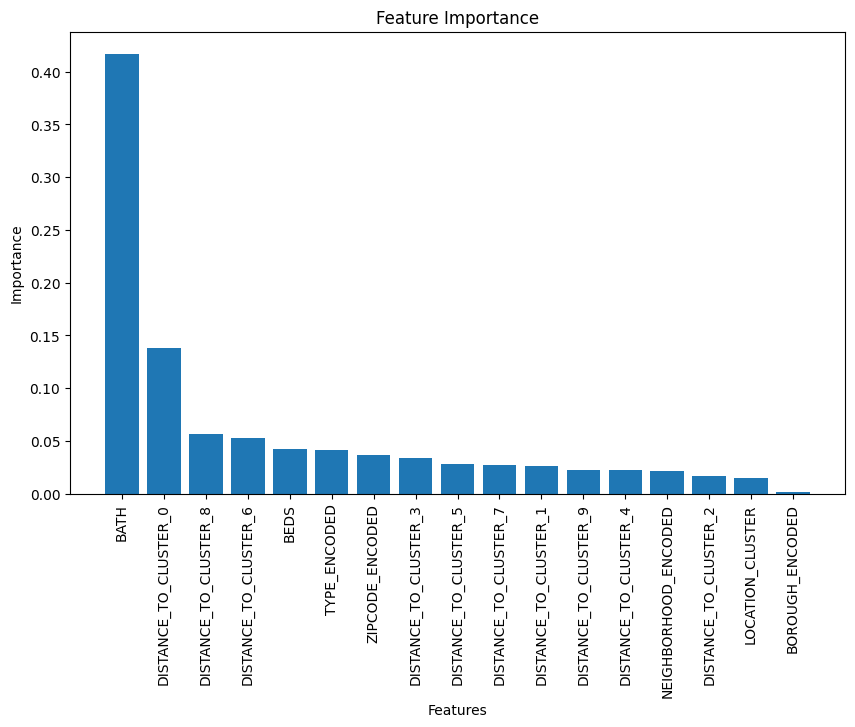

In [33]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

feature_names = X_train.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances, tick_label=feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
